In [2]:
import pyodbc as pyodbc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

DB_SERVER = '192.168.9.64'
DB_PORT = '1433'
DB_NAME = 'ReplCS'
DB_USER = 'soporte_cierre'
DB_PASSWORD = '12345678%'

connStr = ('DRIVER={ODBC Driver 17 for SQL Server};Server=%s,%s;port=%s;Database=%s;uid=%s;pwd=%s') \
         % (DB_SERVER, DB_PORT, DB_PORT, DB_NAME, DB_USER, DB_PASSWORD)
print(connStr)
cnxn = pyodbc.connect(connStr)
cursor = cnxn.cursor()
print(cnxn, cursor)
print(cursor.execute("SELECT @@SPID").fetchone())

DRIVER={ODBC Driver 17 for SQL Server};Server=192.168.9.64,1433;port=1433;Database=ReplCS;uid=soporte_cierre;pwd=12345678%
<pyodbc.Connection object at 0x7fca10dedd30> <pyodbc.Cursor object at 0x7fca103497b0>
(339, )


In [3]:
import textwrap
sql = textwrap.dedent("""
select cust.name, ordr.cust_code, COUNT(1) as tickets
from ordr WITH(NOLOCK)
JOIN ordl WITH(NOLOCK) on   ordr.order_code=ordl.order_code 
						and ordr.order_date=ordl.order_date
JOIN schd WITH(NOLOCK) on  schd.order_date = ordl.order_date	
							AND schd.order_code = ordl.order_code 
							AND schd.order_intrnl_line_num = ordl.order_intrnl_line_num								
JOIN schl WITH(NOLOCK) ON  schd.order_date = schl.order_date 
							AND schd.order_code = schl.order_code 
							AND schd.order_intrnl_line_num = schl.order_intrnl_line_num	
							AND schd.sched_num = schl.sched_num							
JOIN tick AS tick WITH (NOLOCK) ON schl.order_date = tick.order_date 
									AND schl.order_code = tick.order_code 
									AND schl.tkt_code = tick.tkt_code 
									AND schl.order_intrnl_line_num = tick.rm_mix_order_intrnl_line_num 
									AND schl.sched_num = tick.sched_num
JOIN cust(nolock) on cust.cust_code = ordr.cust_code
where ordr.order_date = convert(date,getdate())
	AND (schd.remove_rsn_code IS NULL OR schd.remove_rsn_code = 'LIM')
	AND (schl.remove_rsn_code IS NULL OR schl.remove_rsn_code = 'LIM')
	AND (tick.remove_rsn_code IS NULL OR tick.remove_rsn_code = 'LIM')
	AND (ordr.remove_rsn_code IS NULL OR ordr.remove_rsn_code = 'LIM')
	AND (tick.reused_order_date IS NULL AND tick.reused_order_code IS NULL)
	AND (RTRIM(LTRIM(ordl.prod_code)) <> '000015' AND RTRIM(LTRIM(ordl.prod_code)) <> '000735') /* codigo de servicio bombeo Unicon y Concremax */
	AND NOT(ordr.stat = '4' AND tick.tkt_code IS NULL)	
	AND (/* Solo concreto */
		COALESCE(tick.truck_type, schd.truck_type) NOT IN ('TK','BP','BE') AND 
		COALESCE(tick.truck_type, schd.truck_type) IS NOT NULL AND 
		RTRIM(LTRIM(ordl.short_prod_descr)) <> 'PROGRAMACION DE'
	) /* Solo concreto */
group by cust.name, ordr.cust_code
order by 3 desc
""")

In [4]:
df = pd.read_sql(sql, cnxn)
df.head(10)

name   cust_code  tickets
0  CONSORCIO HV- DVC                         043877           36
1  SERVICIOS GENERALES JHAN MARCO E.I.R.L    008426           26
2  INMOBILIARIA SAN DIEGO DE ALCALA S.A.C.   040072           24
3  G Y M S.A.                                000177           20
4  MACOM R.M. CONTRATISTAS GENERALES S.A.C.  006829           20
5  LA VIGA S. A.                             005001           17
6  J.E. CONSTRUCCIONES GENERALES S.A.        003115           14
7  ESPARQ CIESA CONTRATISTAS GENERALES S.A.  000711           14
8  LIDER INGENIERIA Y CONSTRUCCION S.A.      018732           14
9  CORONEL EJECUTORES E.I.R.L.               024350           14

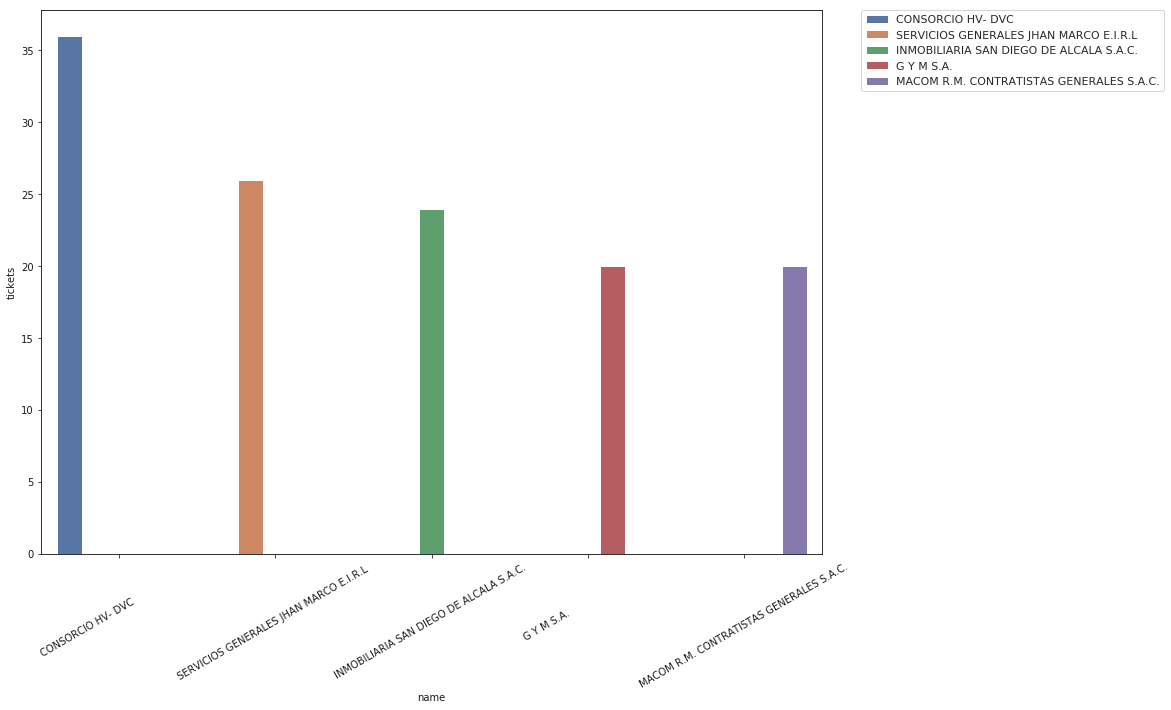

In [5]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.set(font_scale=0.8)
sns.set(style="whitegrid")
ax = sns.barplot(x="name", y="tickets", hue="name", data=df.head(5))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

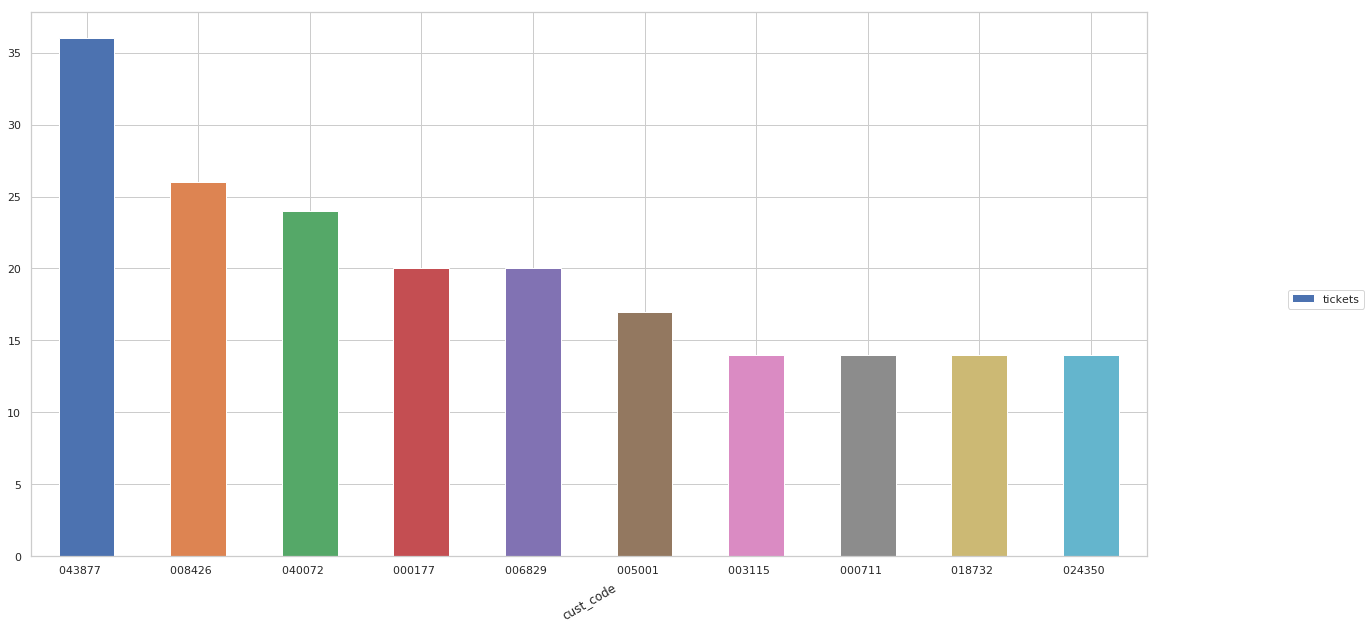

In [6]:
ax = df.head(10).plot.bar(x='cust_code', y='tickets', rot=0, figsize=(20,10)).legend(bbox_to_anchor=(1.2, 0.5))
for i in ax.get_figure().axes:
    plt.sca(i)
    plt.xlabel(i.get_xlabel(), rotation=30)

In [67]:
sql = textwrap.dedent("""
select cust.name, ordr.cust_code, COUNT(1) as despachos
from ordr WITH(NOLOCK)
JOIN ordl WITH(NOLOCK) on   ordr.order_code=ordl.order_code 
						and ordr.order_date=ordl.order_date
JOIN schd WITH(NOLOCK) on  schd.order_date = ordl.order_date	
							AND schd.order_code = ordl.order_code 
							AND schd.order_intrnl_line_num = ordl.order_intrnl_line_num								
JOIN schl WITH(NOLOCK) ON  schd.order_date = schl.order_date 
							AND schd.order_code = schl.order_code 
							AND schd.order_intrnl_line_num = schl.order_intrnl_line_num	
							AND schd.sched_num = schl.sched_num
JOIN cust(nolock) on cust.cust_code = ordr.cust_code
where ordr.order_date = convert(date,getdate())
	AND (ordr.remove_rsn_code IS NULL OR ordr.remove_rsn_code = 'LIM')
	AND (schd.remove_rsn_code IS NULL OR schd.remove_rsn_code = 'LIM')
	AND (schl.remove_rsn_code IS NULL OR schl.remove_rsn_code = 'LIM')
	AND (RTRIM(LTRIM(ordl.prod_code)) <> '000015' AND RTRIM(LTRIM(ordl.prod_code)) <> '000735') /* codigo de servicio bombeo Unicon y Concremax */
	AND NOT(ordr.stat = '4')	
	AND (/* Solo concreto */
		schd.truck_type NOT IN ('TK','BP','BE') AND 
		schd.truck_type IS NOT NULL AND 
		RTRIM(LTRIM(ordl.short_prod_descr)) <> 'PROGRAMACION DE'
	) /* Solo concreto */
group by cust.name, ordr.cust_code
order by 3 desc
""")

In [68]:
df = pd.read_sql(sql, cnxn)
df.head(30)

name   cust_code  despachos
0   CONSORCIO HV- DVC                         043877            115
1   COSAPI S.A.                               000149             42
2   G Y M S.A.                                000177             27
3   INMOBILIARIA SAN DIEGO DE ALCALA S.A.C.   040072             27
4   CONSTRUCTORA INARCO PERU S.A.C.           021954             26
5   MACOM R.M. CONTRATISTAS GENERALES S.A.C.  006829             21
6   FLESAN DEL PERU S.A.C.                    014911             17
7   LA VIGA S. A.                             005001             17
8   SERVICIOS GENERALES JHAN MARCO E.I.R.L    008426             17
9   VIVIENDAS DEL PERU S.A.C.                 015490             16
10  J.E. CONSTRUCCIONES GENERALES S.A.        003115             14
11  LIDER INGENIERIA Y CONSTRUCCION S.A.      018732             14
12  SACYR CONSTRUCCION S.A. SUCURSAL DEL PER  038463             14
13  CLASEM SAC                                020790             13
14  ALDESA CONSTRUCCIONES SA SUCURSAL EN PER  027495             13
15  ESPARQ CIESA CONTRATISTAS GENERALES S.A.  000711             13
16  3 F CONSTRUCTORA EIRL                     016872             13
17  HPC CONSTRUCTORA Y DESARROLLO SAC         028675             11
18  SANTA CRUZ INVERSIONES GENERALES & NEGOC  043885             11
19  CORONEL EJECUTORES E.I.R.L.               024350             10
20  V&V BRAVO S.A.C..                         018592              9
21  HV CONTRATISTAS S. A.                     000091              9
22  COBRA PERU S.A                            001664              8
23  INGENIERIA DE LA CONSTRUCCION S.A.C       013372              8
24  FUJITA GUMI S.A. C.                       000187              7
25  BRAGAGNINI CONSTRUCTORES S.A.C.           000289              7
26  CONCYSSA S.A.                             000662              7
27  CONSORCIO METRO LA COLECTORA SANTA ANITA  034572              7
28  WESCON INGENIERIA Y CONSTRUCCION SAC      036116              7
29  BETON DECKEN S.A.C.                       037975              7

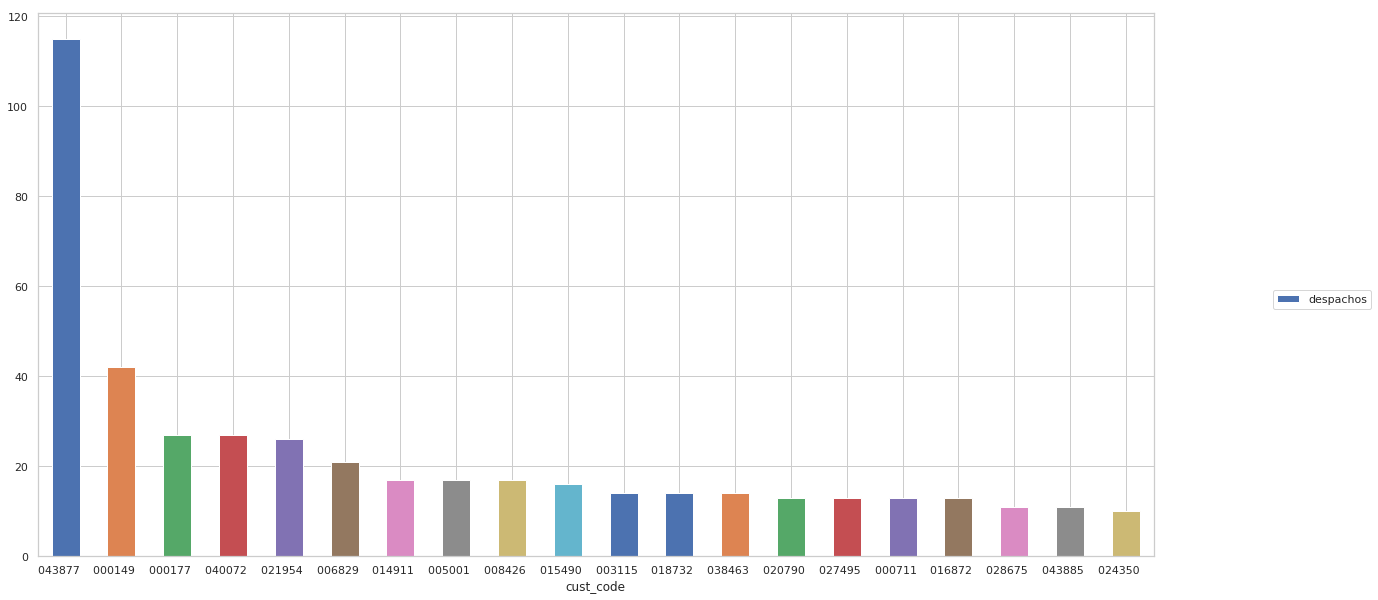

In [70]:
ax = df.head(20).plot.bar(x='cust_code', y='despachos', rot=0, figsize=(20,10)).legend(bbox_to_anchor=(1.2, 0.5))